In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils, visualize_utils
from utils.training_utils import train_model, test_model
from models.spectra_net import SpectraNet
import Simple_RCWA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Initialize and visualize the target spectra

Set a target pattern to search.

The target spectra can be any form, does not need to come from a spectra, this is just for convenience.

Calculation Progress: 100%
freq.shape: (222,)
R_total.shape: (222,)
T_total.shape: (222,)


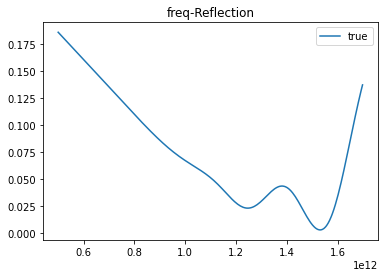

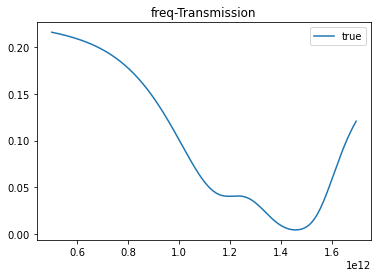

In [3]:
#******************************************************************
'''
Ellipse hole absorber.
'''
# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
# truncate freq over 1.7THz
freq_truncate = 1.7  # in THz
freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12

# ================= Material Structure Define
a = 160.
t = 75.

Lx = a * micrometres  # period along x
Ly = a * micrometres  # period along y
d1 = t * micrometres  # thickness of layer 1

D1 = 150. * micrometres  # two axes of the ellipse hole
D2 = 130. * micrometres

params_eps = [eps_absorber]
params_geometry = [Lx, Ly, [d1]]
params_mesh = [512,512]
order = 7
PQ_order = [order,order]
list_layer_funcs = [Simple_RCWA.utils.rcwa_utils.layerfunc_absorber_ellipse_hole]
list_layer_params = [[D1, D2]]
ginc = [0,0,1]  # orig [0,0,1], incident source
EP = [0,1,0]  # orig [0,1,0]
source = [ginc, EP]
device_rcwa = 'gpu'

# ================= RCWA Solver
Si_square_hole = Simple_RCWA.utils.rcwa_utils.Material(freq, params_eps, params_geometry, params_mesh, PQ_order,
                                     list_layer_funcs, list_layer_params, source, device_rcwa)
R_total, T_total = Si_square_hole.rcwa_solve()

print('freq.shape:', freq.shape)
print('R_total.shape:', R_total.shape)
print('T_total.shape:', T_total.shape)
R_target = R_total
T_target = T_total

plt.figure(1)
plt.plot(freq, R_target, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq, T_target, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# Looping to generate data and training

**************************** ROUND 1 ****************************
====== Generate data for training ======
Freq truncated.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 15
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [143. 130.]
Calculation Progress: 100%
----------------
[ 2 / 15 ] [D1, D2] = [ 88. 117.]
Calculation Progress: 100%
----------------
[ 3 / 15 ] [D1, D2] = [133.  76.]
Calculation Progress: 100%
----------------
[ 4 / 15 ] [D1, D2] = [143.  72.]
Calculation Progress: 100%
----------------
[ 5 / 15 ] [D1, D2] = [ 60. 145.]
Calculation Progress: 100%
----------------
[ 6 / 15 ] [D1, D2] = [ 64. 145.]
Calculation Progress: 100%
----------------
[ 7 / 15 ] [D1, D2] = [65. 83.]
Calculation Progress: 100%
----------------
[ 8 / 15 ] [D1, D2] = [125. 136.]
Calculation Progress: 100%
----------------
[ 9 / 15 ] [D1, D2] = [136.  61.]
Calculation Progress: 100%
----------------
[ 10 / 15 ] [D1, D2] = [111.  56

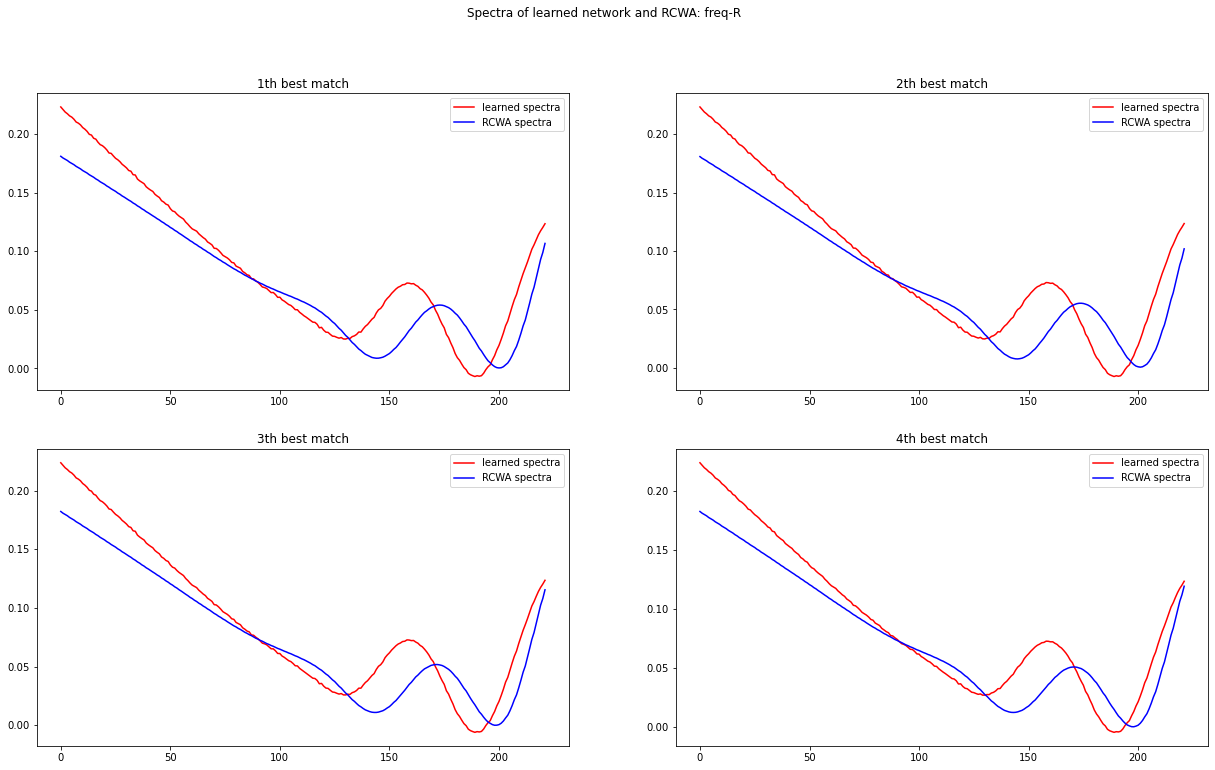

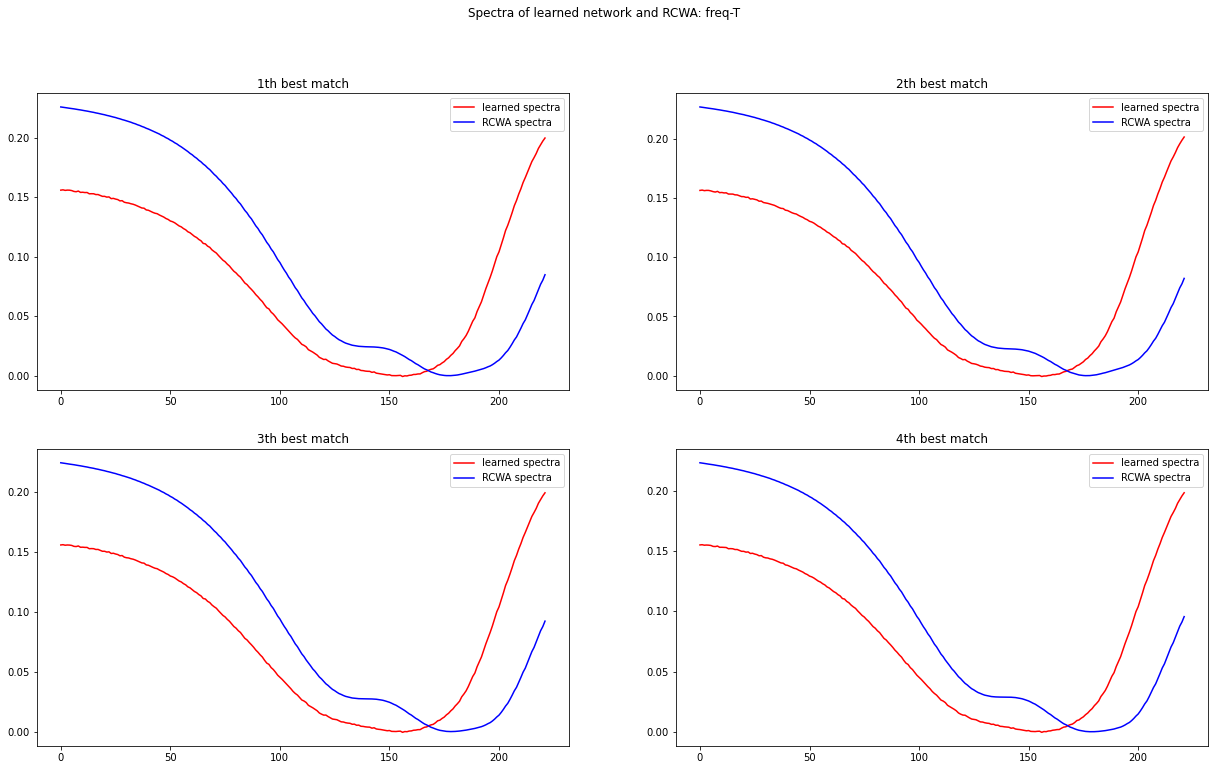

* Model saved.
**************************** ROUND 2 ****************************
====== Generate data for training ======
Freq truncated.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 30
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [ 54. 102.]
Calculation Progress: 40%

In [ ]:
loss_tolerance = 1e-5
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]


# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,151,1]  # [range_start, range_end, step_size]
range_D2 = [50,151,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
pseudo_params = pseudo_params_D1_D2  # [D1,D2]


# ====== Define Target Spectra ======
# tg_idx_freq_R = np.array([129])
# tg_value_R = np.array([0.03])
# tg_idx_freq_T = np.array([0, 167])
# tg_value_T = np.array([0.228, 0.004])
tg_idx_freq_R = np.array(np.arange(222))
tg_value_R = R_target
tg_idx_freq_T = np.array(np.arange(222))
tg_value_T = T_target
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Sampled Data from RCWA Simulation ======
    print('====== Generate data for training ======')
    num_data = 15
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, 
                                                     params_range, 
                                                     params_decimal, 
                                                     solver_setting_list=solver_setting,
                                                     path_material_name=path_material_name, 
                                                     import_list=import_list, 
                                                     use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    # save round sampled data
    path_sampled_data_round = './data/' + path_material_name + '/sampled_data_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_sampled_data_round, params=params, R=R, T=T)
    print('* Round sampled data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = np.array([]).reshape((0,params.shape[-1]))
        R_all = np.array([]).reshape((0,R.shape[-1]))
        T_all = np.array([]).reshape((0,T.shape[-1]))
    params_all = np.concatenate((params_all, params), axis=0)
    R_all = np.concatenate((R_all, R), axis=0)
    T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)  # [N,p]
    print('R_all.shape:', R_all.shape)  # [N,N_freq]
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('* All rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # initiate the network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net = SpectraNet(dim_in,dim_out)
        net = net.to(device)
    
    # train network
    print('====== Train network ======')
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    N_epoch = 2000  # number of epochs trained
    early_stop_parser=[True, 1000, 100]  # [use_early_stop, num_epoch_force, num_epoch_tolerance]
    loss_train, loss_test, net = training_utils.train_model(dataloader, 
                                                            dataloader_test, 
                                                            optimizer, 
                                                            criteon, 
                                                            net, 
                                                            device, 
                                                            NUM_EPOCH=N_epoch, 
                                                            early_stop_parser=early_stop_parser)
    print('* FINAL TRAIN LOSS:', loss_train)
    print('* FINAL TEST LOSS', loss_test)
    
    # visualize spectra on the test set
#     visualize_utils.visualize_trained_net(dataloader_test, net, device)
    
    
    # ====== Spectra Search ======
    print('====== Spectra search ======')
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, 
                                                                          net, 
                                                                          device, 
                                                                          PATH_pseudo_dataset='', 
                                                                          flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('pseudo_params.shape:', pseudo_params.shape)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
#     visualize_utils.visualize_spectra_search(params_pick, R_pick, T_pick)
    # save picked design params for visualization (*optional)
    path_params_pick_visual = './data/' + path_material_name + '/params_pick_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_params_pick_visual, params=params_pick)
    print('* Picked params from spectra search saved.')


    # ====== Add picked samples to training set with a probability ======
    print('====== Add searched params into the training set ======')
    if ROUND==1:
        p_no_add = 1
        beta = 0.8
    else:
        p_no_add *= beta
    print('ROUND %d || p_no_add: %f' %(ROUND, p_no_add))
    R_simu, T_simu = np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(params_pick.shape[0]):  # for each picked sample points
        # run RCWA to get simulated results
        print('Calling RCWA to slove the [%d / %d] th picked params.' % (idx_pick+1, params_pick.shape[0]))
        params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
        rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, 
                                                                               params_decimal, 
                                                                               solver_setting_list=solver_setting,
                                                                               path_material_name=path_material_name, 
                                                                               import_list=import_list, 
                                                                               use_log=True, 
                                                                               flag_spectra_search_rerun=True, 
                                                                               rerun_params=params_pick_rcwa)
        R_simu[idx_pick], T_simu[idx_pick] = R_simu_i, T_simu_i
        if np.random.random_sample()>p_no_add:  # add picked sample to training set
            if np.any(np.all(params_all-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the training set
                print('Picked sample already in the training set.')
            else:
                print('Add picked sample to the training set.')
                params_all = np.concatenate((params_all, rerun_params_i), axis=0)
                R_all = np.concatenate((R_all, R_simu_i), axis=0)
                T_all = np.concatenate((T_all, T_simu_i), axis=0)
        else:
            print('Picked sample not added.')
        print('------------')
    # update params_list
    path_params_list = './data/' + path_material_name + '/params_list.npz'
    np.savez(path_params_list, params_list=params_all)
    # save round all data + added picked data
    path_all_data_round = './data/' + path_material_name + '/all_data_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params_all, R=R_all, T=T_all)
    print('* Round all data saved.')
    
    
    # ====== MSE between learned spectra and simulated spectra ======
    print('====== Loss between learned spectra and simulated spectra ======')
    mse_R = ((R_pick - R_simu)**2).mean(axis=-1)  # [N_top]
    mse_T = ((T_pick - T_simu)**2).mean(axis=-1)
    mse = (mse_R + mse_T) / 2
    print('* MSE_R for each:', mse_R)
    print('* MSE_T for each:', mse_T)
    print('* MSE (averaged on R&T) for each:', mse)
#     print('* AVG MSE_R for all picked params:', np.average(mse_R))
#     print('* AVG MSE_T for all picked params:', np.average(mse_T))
#     sqrt_mse_R = np.average(np.sqrt(mse_R))
#     sqrt_mse_T = np.average(np.sqrt(mse_T))
#     loss_mse = np.average([sqrt_mse_R, sqrt_mse_T])
#     print('* sqrt MSE_R:', sqrt_mse_R)
#     print('* sqrt MSE_T:', sqrt_mse_T)
#     print('* LOSS_SQRT_MSE:', loss_mse)
    loss = np.average(mse)  # avg loss among all picked params for both R&T should be small enough
    print('* CURRENT ROUND LOSS:', loss)

    # visualize learned spectra and RCWA true spectra
    visualize_utils.visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/SpectraNet_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net.state_dict(), PATH_MODEL)
    print('* Model saved.')
    
    ROUND += 1
    
plt.ioff()

## Save the trained model

In [ ]:
PATH_MODEL = './trained_models/' + path_material_name + '/SpectraNet_final.pt'
torch.save(net.state_dict(), PATH_MODEL)
print('Model saved.')